# PyQNI demonstration notebook - Hydrogen based materials

## Introduction

This notebook demonstrates how to create objects for hydrogen based materials for quantitative neutron imaging using PyQNI. The hydrogen atom cross section is a special case because of the large impact of inelastic interactions. As a result, the hydrogen cross section depends not only on the volume density of hydrogen atoms, but also on their mobility due to molecular vibrations or diffusion processes. Therefore, the cross section to be used needs to be carefully considered.

## Imports

First, we import the PyQNI framework. If the notebook is placed in te different location, the PyQNI framework path has to be updated.

In [1]:
import sys
sys.path.append(r'C:\Software\pyqni\framework') # update path if necessary
from PyQNI import compound, beam, detector

We will also use the *matplotlib* package to display charts and the *numpy* package to work with arrays.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Water

Water is a predefined material, so it usually does not need to be created and can simply be imported. However, it is a good illustration of why it is necessary to select the correct hydrogen cross sections.

### Definition of water as a compound

A *compound* in PyQNI is a material which can be defined by a simple molecular formula (e.g. $H_2O$). To specify it, we only need to precise the elements composing it and their stoichiometries (*composition* parameter) and its specific weight (*spec_weight* parameter). Here, we define water according to its formula:

In [3]:
water_endf = compound(composition={'H-1-ENDF':2.0, 'O':1.0}, spec_weight=1.0)

Note that for the oxygen component we simply specified the element 'O'. In that case, PyQNI will use the natural isotopic composition. The cross sections of the corresponding isotopes included in PyQNI were obtained from the ENDF/B VIII cross section database. The hydrogen cross section depends on the chemical compound and its physical state. In consequence, to avoid mistakes, it is not possible in PyQNI to simply specify 'H' as an element, and more precisions need to be given. Hereabove, we used 'H-1-ENDF', which means the $^1$H isotope according to the cross section data in ENDF/B VIII. As we will see later on, this is actually a very bad choice for water.

We can then get and plot the cross sections and the linear attenuation coefficients of this compound as a function of energy. As a default, the values are computed for an energy range from 0.1 meV to 10 eV, with 100 values per decade in a geometric progression.

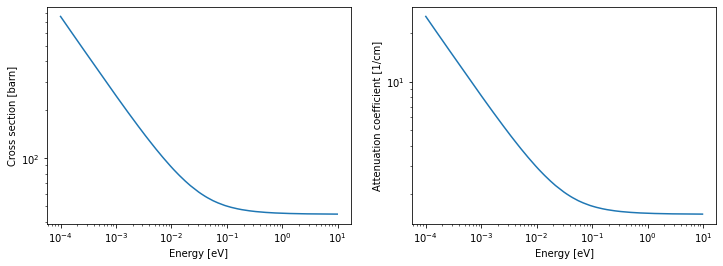

In [4]:
e_endf,xs_endf = water_endf.cross_sections()
e_endf,ac_endf = water_endf.att_coeff()

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.loglog(e_endf,xs_endf)
plt.xlabel('Energy [eV]')
plt.ylabel('Cross section [barn]')

plt.subplot(1, 2, 2)
plt.loglog(e_endf,ac_endf)
plt.xlabel('Energy [eV]')
plt.ylabel('Attenuation coefficient [1/cm]')

plt.show()

For those who are familiar with the water attenuation spectrum, this doesn't look quite correct. What happened ? The cross sections are taken from a copy of the ENDF-VIII database, where the scattering cross sections use the free gas approximation. For many elements this is sufficient, but for H this induces important errors.

### Definition of water from realistic cross sections

Instead of using the hydrogen cross sections from the ENDF database, we can use experimentally measured cross sections. A few 'special' cross sections are defined for hydrogen compounds (they are found in the *xs_special* subfolder of *xs_data* of PyQNI). To define water, we use the *'H-1-H2O-EXS'* element, which represents the cross section of hydrogen when bound in water. This cross section is based on experimental data for H$_2$O from the EXFOR database (using the data from Heinloth et al. for the low energies and from Russel et al. for the higher energies), which was smoothed and interpolated ('exs' stands here for __EX__FOR __S__moothed).

In [5]:
water_exs = compound(composition={'H-1-H2O-EXS':2.0, 'O':1.0}, spec_weight=1.0)

And we plot the cross section, which significantly differs from the free gas approximation.

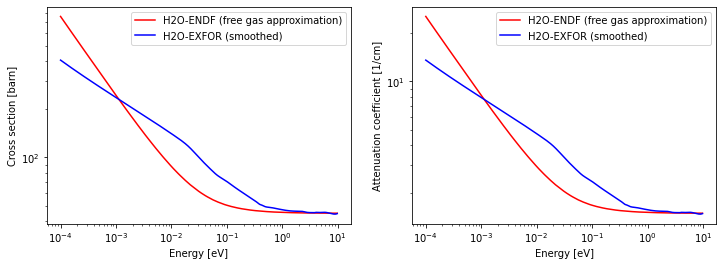

In [6]:
e_exs,xs_exs = water_exs.cross_sections()
e_exs,ac_exs = water_exs.att_coeff()

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.loglog(e_endf,xs_endf,'r-')
plt.loglog(e_exs,xs_exs,'b-')
plt.xlabel('Energy [eV]')
plt.ylabel('Cross section [barn]')
plt.legend(['H2O-ENDF (free gas approximation)', 'H2O-EXFOR (smoothed)'])

plt.subplot(1, 2, 2)
plt.loglog(e_endf,ac_endf,'r-')
plt.loglog(e_exs,ac_exs,'b-')
plt.xlabel('Energy [eV]')
plt.ylabel('Attenuation coefficient [1/cm]')
plt.legend(['H2O-ENDF (free gas approximation)', 'H2O-EXFOR (smoothed)'])

plt.show()

### Impact on effective attenuation coefficients

We can see the impact of the use of these different cross sections when computing an effective attenuation coefficient for water (for detailed explanations on this computation, see the notebook "PyQNI_demo_H2O").

We select the NEUTRA beam:

In [7]:
neutra = beam('NEUTRA')

And we define a detector based on a 40 micrometer thick Gadox screen:

In [8]:
from PyQNI_scintillators import gadox_sc
gadox40 = detector(gadox_sc, thickness=0.004)

Finally, we compute the effective cross sections of our ENDF and EXFOR based water materials:

In [9]:
water_xs_endf = water_endf.eff_att_coeff(neutra, gadox40)
water_xs_exs = water_exs.eff_att_coeff(neutra, gadox40)
print('Water effective attenuation coefficient (ENDF based): {:.4g} cm^-1'.format(water_xs_endf))
print('Water effective attenuation coefficient (EXFOR based): {:.4g} cm^-1'.format(water_xs_exs))

Water effective attenuation coefficient (ENDF based): 2.164 cm^-1
Water effective attenuation coefficient (EXFOR based): 3.432 cm^-1


The difference between the two values illustrate how important it is to use the experimental hydrogen cross sections

## Polymers

In most polymers (excepted perfluorinated polymers such as PTFE), the neutron attenuation is mostly due to hydrogen. Here, we will show an example where the neutron transmission though a given thickness of different polymers (PE, PEEK, PPS) needs to be known, for example if it needs to be known which thickness of these materials can be tolerated in a sample environment.

### Definition of the material

First, we define polyethylene (PE) according to the chemical formula of its repeating unit $(C_2H_4)_n$ and assuming a specific weight of 0.9 g/cm^3:

In [10]:
pe = compound({'C':1, 'H-1-PE-EXS':2}, spec_weight=0.9)

Note that the used hydrogen cross section is different than from the water example above. In this case, we used the cross section of hydrogen in polyethylene (PE) from the EXFOR database.

Then, we define PEEK according to the chemical formula of its repeating unit $(C_{19}O_3H_{12})_n$ and assuming a specific weight of 1.32 g/cm^3:

In [11]:
peek = compound({'C':19, 'O':3, 'H-1-PE-EXS':12}, spec_weight=1.32)

There is no experimental cross section of PEEK available in the EXFOR database, so we used the cross section of PE as the best available approximation.

We do the same for the PPS polymer with formula $(C_6H_4S)_n$, assuming a specific weight of 1.35 g/cm^3:

In [12]:
pps = compound({'C':6, 'H-1-PE-EXS':4, 'S':1}, spec_weight=1.35)

### Computation of the transmission as a function of the thickness

We can obtain the relation between thickness and transmission from the 'get_converter' method of the materials (for detailed explanations about how this works, see the notebook "PyQNI_demo_H2O"). The beam and detector have to be specified to take into account the beam hardening effects):

In [13]:
conv_pe = pe.get_converter(neutra, gadox40, result='trans')
conv_peek = peek.get_converter(neutra, gadox40, result='trans')
conv_pps = pps.get_converter(neutra, gadox40, result='trans')

Then, we can use this converter to compute the transmission for different thicknesses (we chose the range from 0 to 2 cm here):

In [14]:
mat_thicknesses = np.linspace(0, 2, 100)
pe_transmissions = conv_pe(mat_thicknesses)
peek_transmissions = conv_peek(mat_thicknesses)
pps_transmissions = conv_pps(mat_thicknesses)

And we plot the results:

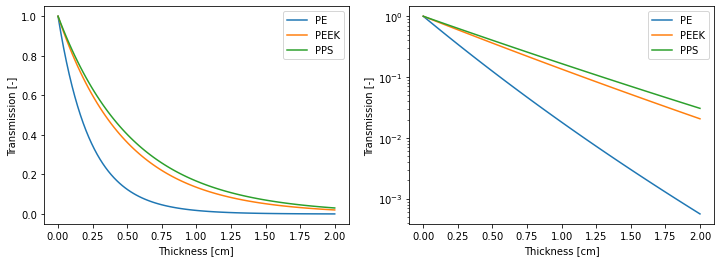

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(mat_thicknesses, pe_transmissions)
plt.plot(mat_thicknesses, peek_transmissions)
plt.plot(mat_thicknesses, pps_transmissions)
plt.xlabel('Thickness [cm]')
plt.ylabel('Transmission [-]')
plt.legend(['PE', 'PEEK', 'PPS'])

plt.subplot(1, 2, 2)
plt.semilogy(mat_thicknesses, pe_transmissions)
plt.semilogy(mat_thicknesses, peek_transmissions)
plt.semilogy(mat_thicknesses, pps_transmissions)
plt.xlabel('Thickness [cm]')
plt.ylabel('Transmission [-]')
plt.legend(['PE', 'PEEK', 'PPS'])

plt.show()

Despite their higher density, the PEEK and PPS polymers result in a lower attenuation than PE, as they have a lower hydrogen fraction.

## Organic compounds

### Pure compounds

Here we show the computation of the attenuation of a few common organic compounds. Unfortunately, the exact H cross section for such compounds is not known, so we will show only approximations using the H cross sections of water and PE.

Hereunder we create the compounds methanol ($CH_4O$), ethanol ($C_2H_6O$), isopropanol ($C_3H_8O$) and acetone ($C_3H_6O$) using the water cross sections:

In [16]:
org_comp_xs_H2O = {
    'methanol': compound({'C':1, 'H-1-H2O-EXS':4, 'O':1}, spec_weight=0.7909),
    'ethanol': compound({'C':2, 'H-1-H2O-EXS':6, 'O':1}, spec_weight=0.7893),
    'isopropanol': compound({'C':3, 'H-1-H2O-EXS':8, 'O':1}, spec_weight=0.7855),
    'acetone': compound({'C':3, 'H-1-H2O-EXS':6, 'O':1}, spec_weight=0.7902),
}

And using the PE cross sections:

In [17]:
org_comp_xs_PE = {
    'methanol': compound({'C':1, 'H-1-PE-EXS':4, 'O':1}, spec_weight=0.7909),
    'ethanol': compound({'C':2, 'H-1-PE-EXS':6, 'O':1}, spec_weight=0.7893),
    'isopropanol': compound({'C':3, 'H-1-PE-EXS':8, 'O':1}, spec_weight=0.7855),
    'acetone': compound({'C':3, 'H-1-PE-EXS':6, 'O':1}, spec_weight=0.7902),
}

And we compute the corresponding attenuation coefficients:

In [18]:
org_comp_names = org_comp_xs_H2O.keys()
org_comp_ac_H2O = [x.eff_att_coeff(neutra, gadox40) for x in org_comp_xs_H2O.values()]
org_comp_ac_PE = [x.eff_att_coeff(neutra, gadox40) for x in org_comp_xs_PE.values()]
org_comp_ac = pd.DataFrame({'Using H2O xs':org_comp_ac_H2O, 'Using PE xs':org_comp_ac_PE}, index=org_comp_names)

In [19]:
print(org_comp_ac)

             Using H2O xs  Using PE xs
methanol         3.069499     3.318272
ethanol          3.201870     3.460934
isopropanol      3.260009     3.523555
acetone          2.583071     2.788769


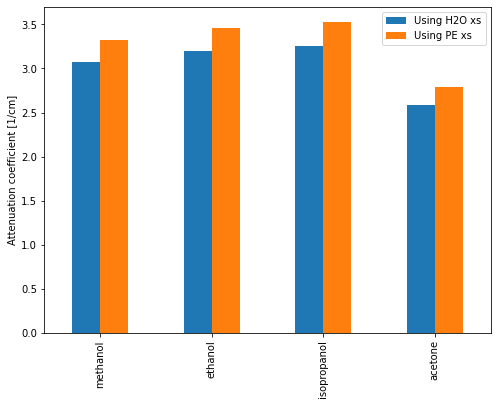

In [20]:
org_comp_ac.plot.bar(figsize=(8,6))
plt.ylabel('Attenuation coefficient [1/cm]')
plt.show()

### Mixtures

When different compounds are mixed, the attenuation coefficient can be computed by ponderating the attenuation coefficients of the individual compounds with their volume fraction. This is done automatically by the PyQNI *mixture* object. Here, we will demonstrate how this can be done for computing the cross sections of mixtures of ethanol in water

We import the *mixture* object:

In [21]:
from PyQNI import mixture

We also import the predefined *water* object, and re-use the *ethanol* compound defined previously in this notebook (choosing the one based on the PE cross section)

In [22]:
from PyQNI_materials import water
ethanol = org_comp_xs_PE['ethanol']

We then create the mixture. The fraction of ethanol is not given numerically, but is given as a variable ('c'). We specify that we are using mass fractions, which will automatically be converted to volume fractions.

In [23]:
diluted_ethanol_simple = mixture([(ethanol,'c'), water], frac_type='mass')

If no specific weight for the mixture is given, it will be assumed that the total volume is the sum of the volumes of the individual compounds, and the mixture specific weight will be computed accordingly. But for many mixtures, the reality differs from this assumption.

For mixtures of water and ethanol, tabulated values can be used to know the specific weight as a function of the ethanol mass fraction. In this example, the values at 25°C are obtained from the CRC Handbook of Chemistry and Physics (*https://hbcp.chemnetbase.com/faces/documents/15_20/15_20_0001.xhtml*). Here, we define two arrays with the concentration and specific weight values, and create an interpolation function *sw_dil_etoh()* to compute the specific weight at any concentration.

In [24]:
from scipy.interpolate import interp1d
c_vals = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
sw_vals = [0.99705, 0.98935, 0.98184, 0.97511, 0.96861, 0.96165, 0.95379, 0.94491, 0.93515, 0.92469, 0.91381, 0.90255,
           0.89110, 0.87945, 0.86763, 0.85561, 0.84341, 0.83093, 0.81795, 0.80422, 0.78932]
sw_dil_etoh = interp1d(c_vals, sw_vals, kind='cubic')

As an illustration, we plot the *sw_dil_etoh()* function:

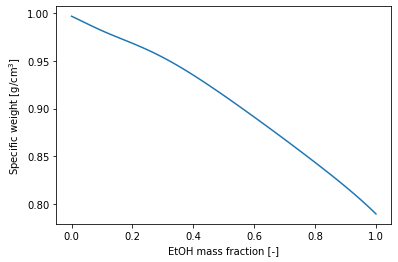

In [25]:
plt.plot(np.linspace(0,1,100), sw_dil_etoh(np.linspace(0,1,100)))
plt.xlabel('EtOH mass fraction [-]')
plt.ylabel('Specific weight [g/cm$^3$]')
plt.show()

And we create a new mixture corresponding to the full calculation, where the specific weight is specified as being a function of the concentration. Note that the name *'sw(c)'* is not yet defined, we will specify it as being our previously computed function when creating the converter functions

In [26]:
diluted_ethanol_full = mixture([(ethanol,'c'), water], frac_type='mass', spec_weight='sw(c)')

We now want to create converter functions which give us the attenuation coefficient as a function of the ethanol concentration. We use the same *get_converter()* method as before, but with some additional specifications. Per default, the get_converter method assume the function parameter is the thickness and the result is the optical density. Here, we specify the parameter as being *'c'* (the ethanol concentration) and the result as being *'ac'* (a predefined code meaning the attenuatino coefficient). We have to specify the *pmin* and *pmax* bounds for the parameter.

For the full calculation, we also specify that our specific weight function is *sw_dil_etoh()*

In [27]:
conv_dil_etoh_simple = diluted_ethanol_simple.get_converter(neutra, gadox40, param='c', pmin=0.0, pmax=1.0, result='ac')
conv_dil_etoh_full = diluted_ethanol_full.get_converter(neutra, gadox40, param='c', pmin=0.0, pmax=1.0, result='ac', sw=sw_dil_etoh)

And we now plot the results. As can be seen, taking into account the tabulated specific weight (full calculation) gives significantly different values.

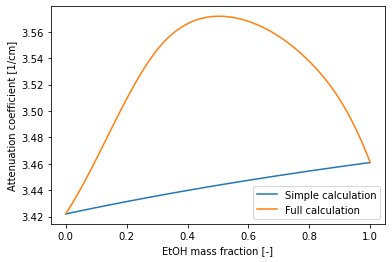

In [28]:
cbase = np.linspace(0,1,100)
plt.plot(cbase, conv_dil_etoh_simple(cbase))
plt.plot(cbase, conv_dil_etoh_full(cbase))
plt.xlabel('EtOH mass fraction [-]')
plt.ylabel('Attenuation coefficient [1/cm]')
plt.legend(['Simple calculation','Full calculation'])
plt.show()

To be remembered: even the full calculation relies on approximate cross sections, using the cross section of hydrogen bound in PE for the ethanol compound. In reality, the H atoms bound in ethanol may have different cross sections.